# Real Estate Linear Regression

## 0. Preparing libraries

In [85]:
#Importing classic libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 

#Importing sklearn model library
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #to make the feature scaling
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns #importing sns class for heatmaps
import math

#Importing Gradient Boosting Regressor
from xgboost import XGBRegressor 
import xgboost as xgb

#Importing sklearn testing library
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, learning_curve
from sklearn.metrics import accuracy_score, f1_score, r2_score, precision_score, recall_score, classification_report, confusion_matrix

#Importing yellowbrick to make residual plot 
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

## 1. Importing dataset

In [86]:
#importing dataset
url_dataset = os.getcwd()+"/real_data_kaggle/realEstateDataset.csv"

df_dataset = pd.read_csv(url_dataset)

#renaming the columns of the features and output
df_dataset = df_dataset.rename({'X1 transaction date':'X1_transaction_date',
                                'X2 house age':'X2_house_age',
                                'X3 distance to the nearest MRT station':'X3_distance_nearest_MRT_station',
                                'X4 number of convenience stores':'X4_N_convenience_stores',
                                'X5 latitude':'X5_latitude','X6 longitude':'X6_longitude',
                                'Y house price of unit area':'Y_house_price_of_unit_area'},axis=1)\
                      .drop('No',axis=1)

rows, columns = df_dataset.shape

print(f"The dataset is a matrix of {columns} columns and {rows} rows")
df_dataset.head()

The dataset is a matrix of 7 columns and 414 rows


,X1_transaction_date,X2_house_age,X3_distance_nearest_MRT_station,X4_N_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [100]:
#Creating a new method to change the types of date
def to_date(data, date_column_name):
    # STEP 1: Convert transaction date to day, month and year columns
    # Create date column with `transaction date` as a date
    data['date'] = pd.to_datetime(data[date_column_name], format='%Y')

    # Create year column
    data['year'] = pd.DatetimeIndex(data['date']).year

    # Create month column by extracting the decimal part of `transaction date` and multiplying it by 12
    data['month'], data['year1'] = data[date_column_name].apply(lambda x: math.modf(x)).str
    data['month'] = data['month']*12

    # Create day column by extracting the decimal part of int
    data['day'], data['month'] = data['month'].apply(lambda x: math.modf(x)).str

    # Convert month to int
    data['month'] = (data['month']).astype(int)

    # Multiply `day` column by 30 + 1 to convert it to days
    data['day'] = (data['day']*30+1).astype(int)

    # Drop unnecessary columns
    data = data.drop([date_column_name, 'date', 'year1'], axis=1, inplace=True)

In [95]:
#Spliting the data into train and test data to make data exploration for the model
train_dataset, test_dataset = train_test_split(df_dataset,test_size=0.2,random_state=1)

print(f"The shape of the train dataset is {train_dataset.shape}")
print(f"The shape of the train dataset is {test_dataset.shape}")

The shape of the train dataset is (331, 7)
The shape of the train dataset is (83, 7)


## 2. Data Exploration

In [96]:
#Displaying general information of the dataset
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 159 to 37
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   X1_transaction_date              331 non-null    float64
 1   X2_house_age                     331 non-null    float64
 2   X3_distance_nearest_MRT_station  331 non-null    float64
 3   X4_N_convenience_stores          331 non-null    int64  
 4   X5_latitude                      331 non-null    float64
 5   X6_longitude                     331 non-null    float64
 6   Y_house_price_of_unit_area       331 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 20.7 KB


In [64]:
#Displaying sample of the dataset
train_dataset.head()

,X1_transaction_date,X2_house_age,X3_distance_nearest_MRT_station,X4_N_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
159,2012.667,15.5,815.93140,4,24.97886,121.53464,37.4
95,2012.917,8.0,104.81010,5,24.96674,121.54067,51.8
11,2013.333,6.3,90.45606,9,24.97433,121.54310,58.1
374,2013.250,5.4,390.56840,5,24.97937,121.54245,49.5
165,2012.917,13.7,1236.56400,1,24.97694,121.55391,30.6


In [65]:
#Displaying general descriptive statistics report
train_dataset.describe()

,X1_transaction_date,X2_house_age,X3_distance_nearest_MRT_station,X4_N_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,2013.169704,17.813595,1052.998068,4.205438,24.969453,121.534048,38.712991
std,0.281697,11.464981,1235.130942,2.926385,0.012370,0.015145,13.814414
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.050000,289.324800,1.000000,24.963050,121.529915,28.450000
50%,2013.167000,16.200000,492.231300,5.000000,24.971100,121.539130,39.300000
75%,2013.417000,29.200000,1410.633500,6.000000,24.978440,121.543480,47.300000
max,2013.583000,42.700000,6488.021000,10.000000,25.014590,121.566270,117.500000


##### Looking graphically the relationship between the output and the features

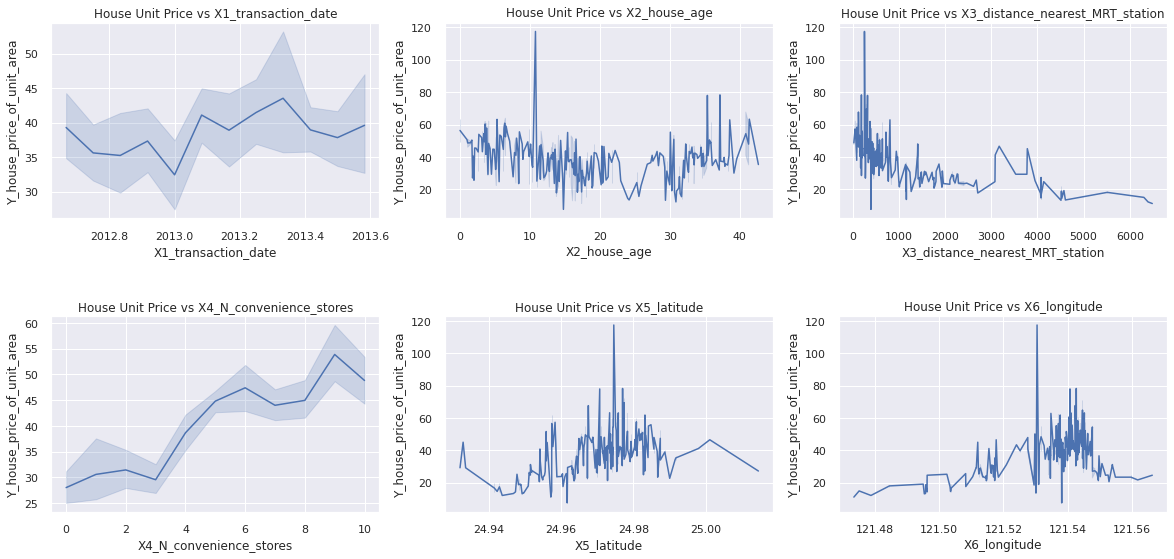

In [66]:
figure, ax = plt.subplots(2,3,figsize=(20,9))
ax = ax.flatten()

#Setting sns (seaborn)
sns.set()
for i in range(columns-1):
  sns.lineplot(data=train_dataset, x=test_dataset.columns[i],y='Y_house_price_of_unit_area',ax=ax[i])
  ax[i].set_title(f"House Unit Price vs {test_dataset.columns[i]}")

plt.subplots_adjust(hspace=0.5)
plt.show()

##### Distribution

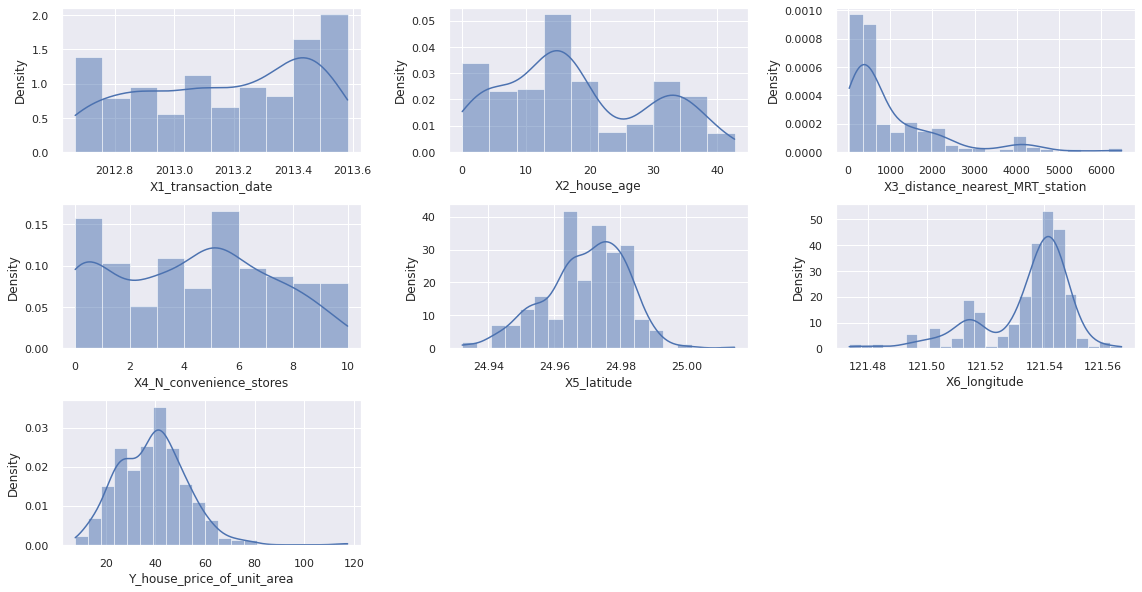

In [67]:
#Displaying the histograms for each feature
def display_histograms(train_dataset):
  figure = plt.figure(figsize=(16,16))

  #Way to create a loop and getting per each loop the index value and the column name
  for index,col in enumerate(train_dataset):
    plt.subplot(6,3,index+1)
    sns.histplot(train_dataset.loc[:,col].dropna(),kde=True, stat='density',linewidth=0.5)

  figure.tight_layout(pad=1.0)

display_histograms(train_dataset)

BoxPlots

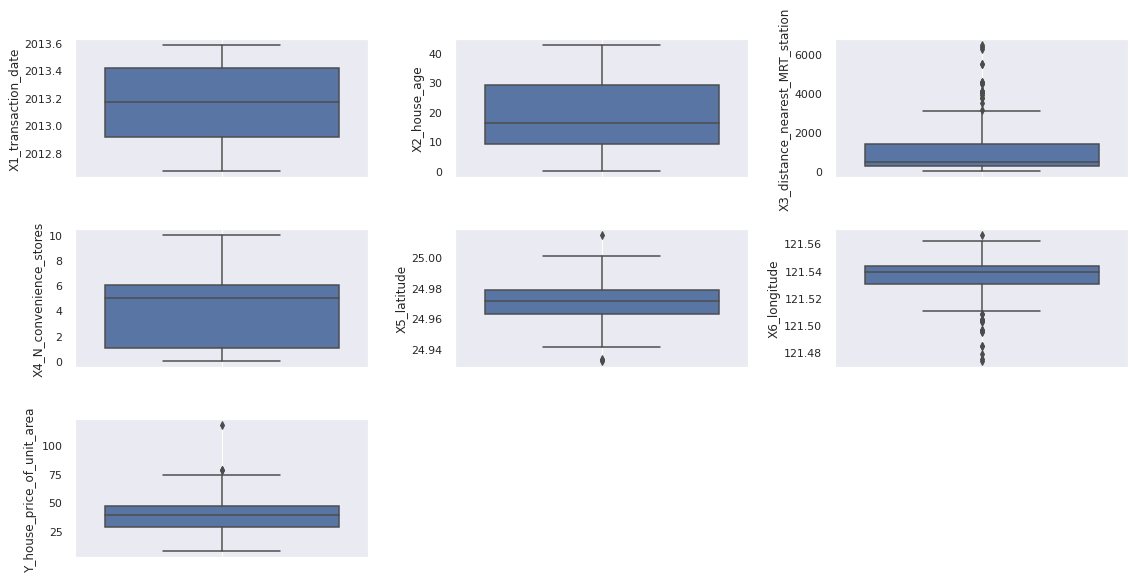

In [68]:
#Displaying the boxplot for each feature
def display_botxplots(train_dataset):
  figure = plt.figure(figsize=(16,16))

  #Way to create a loop and getting per each loop the index value and the column name
  for index,col in enumerate(train_dataset):
    plt.subplot(6,3,index+1)
    sns.boxplot(y=col, data=train_dataset.dropna())
    plt.grid()

  figure.tight_layout(pad=1.0)

display_botxplots(train_dataset)

## 3. Data Cleaning

In [69]:
# Removing outliers, based on the histograms and boxplots
train_dataset_cleaned = train_dataset[train_dataset['X3_distance_nearest_MRT_station']<3000]
train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['Y_house_price_of_unit_area']<80]
train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['X6_longitude']>121.50]

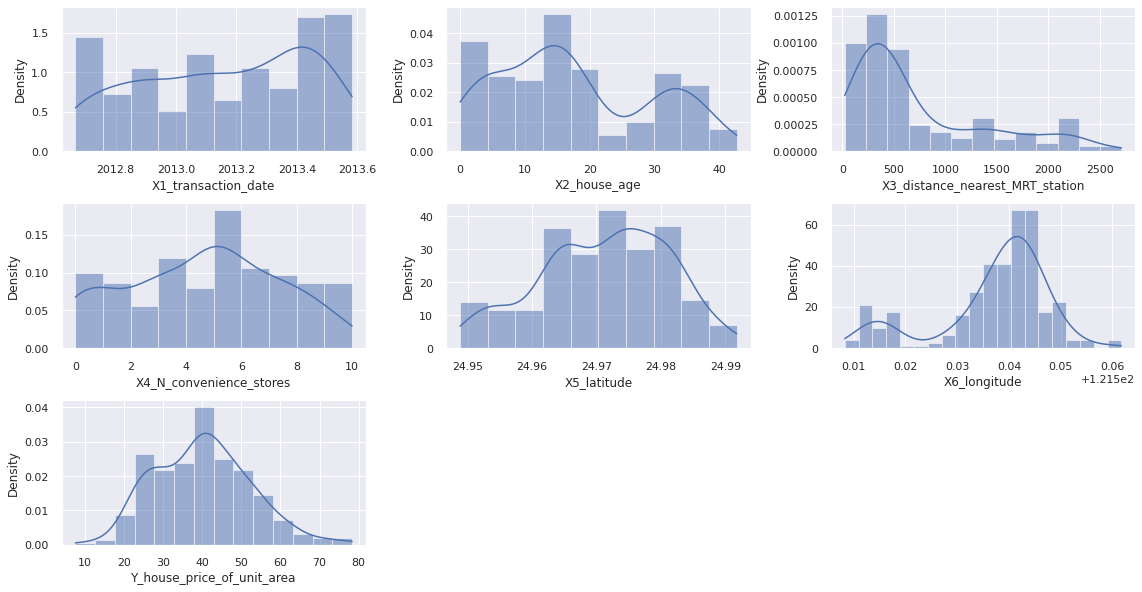

In [70]:
display_histograms(train_dataset_cleaned)

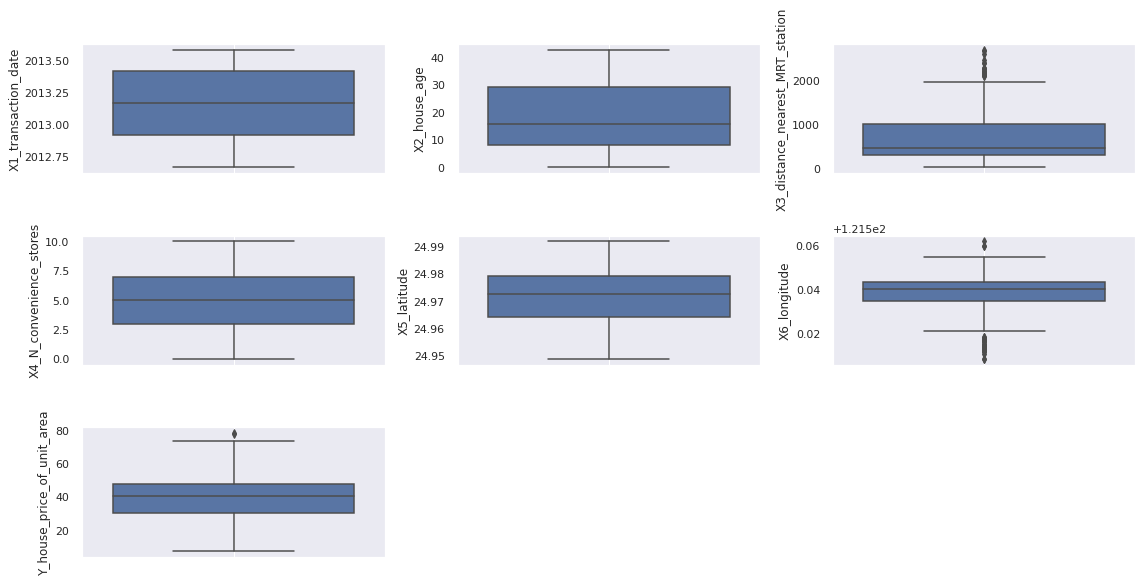

In [71]:
display_botxplots(train_dataset_cleaned)

We are going to use the transaction date so let's convert the date in a different format

In [101]:
df_train_test = pd.concat([train_dataset_cleaned,test_dataset])
to_date(df_train_test,"X1_transaction_date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  from ipykernel import kernelapp as app


## 4. Making the Regression Model

Spliting the X features matrix and the y vector

In [73]:
# Split the data into X and y
X=df_train_test.drop('Y_house_price_of_unit_area',axis=1)
y=df_train_test['Y_house_price_of_unit_area']

Feature Scaling

In [102]:
#using the StandardScaler class to make the scaling
transformer = StandardScaler().fit(X)
X_prep = transformer.transform(X)

Polinomial Features

In [77]:
# Polynomial Features (degree 2)
polynomial_converter = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform
poly_features = polynomial_converter.fit(X_prep)
poly_features = polynomial_converter.transform(X_prep)

Spliting Data (training and test)

In [103]:
#Spliting data based on the poly_features training dataset
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=1)
print(f"First split: X_train -> {X_train.shape} y_train -> {y_train.shape}")

First split: X_train -> (307, 44) y_train -> (307,)


### **XGBRegressor**

In [104]:
# Fit the model
model_xgbr = XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 0, max_depth = 3)
model_xgbr.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror', seed=0)

In [105]:
# Predict on train data
pred_train_xgbr = model_xgbr.predict(X_train)

r2_train_xgbr = r2_score(y_train, pred_train_xgbr)
mse_train_xgbr = mean_squared_error(y_train, pred_train_xgbr)
rmse_train_xgbr = np.sqrt(mse_train_xgbr)
mae_train_xgbr = mean_absolute_error(y_train, pred_train_xgbr)
print(r2_train_xgbr)

0.9511620347058908


In [106]:
# Predict on train data
pred_test_xgbr = model_xgbr.predict(X_test)

r2_test_xgbr = r2_score(y_test, pred_test_xgbr)
mse_test_xgbr = mean_squared_error(y_test, pred_test_xgbr)
rmse_test_xgbr = np.sqrt(mse_test_xgbr)
mae_test_xgbr = mean_absolute_error(y_test, pred_test_xgbr)
print(r2_test_xgbr)

0.7624674964757178


In [84]:
pd.DataFrame({'Testing':  [r2_test_xgbr, mse_test_xgbr, rmse_test_xgbr, mae_test_xgbr],
               'Training': [r2_train_xgbr, mse_train_xgbr, rmse_train_xgbr, mae_train_xgbr],
             },
              index=['R2', 'MSE', 'RMSE', 'MAE'])

,Testing,Training
R2,0.762467,0.951162
MSE,40.237455,7.296321
RMSE,6.343300,2.701170
MAE,4.546997,2.103246


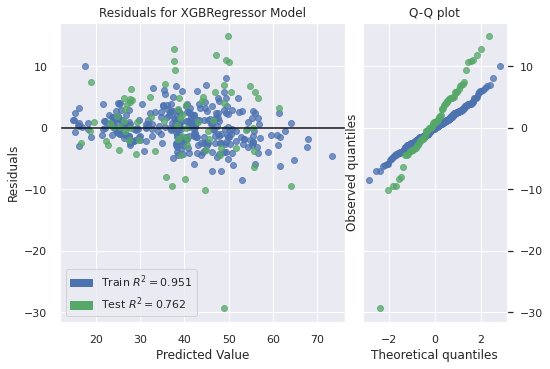

In [107]:
visualizer = ResidualsPlot(model_xgbr, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

### **Linear Regression**

In [91]:
model_poly = LinearRegression()
model_poly.fit(X_train,y_train)

LinearRegression()

In [93]:
# Predict on train data
pred_train_poly = model_poly.predict(X_train)

r2_train_poly = r2_score(y_train, pred_train_poly)
mse_train_poly = mean_squared_error(y_train, pred_train_poly)
rmse_train_poly = np.sqrt(mse_train_poly)
mae_train_poly = mean_absolute_error(y_train, pred_train_poly)

print(r2_train_poly)

0.7669664580922528


In [94]:
# Predict on test data
pred_test_poly = model_poly.predict(X_test)

r2_test_poly = r2_score(y_test, pred_test_poly)
mse_test_poly = mean_squared_error(y_test, pred_test_poly)
rmse_test_poly = np.sqrt(mse_test_poly)
mae_test_poly = mean_absolute_error(y_test, pred_test_poly)

print(r2_test_poly)

0.690240679384048


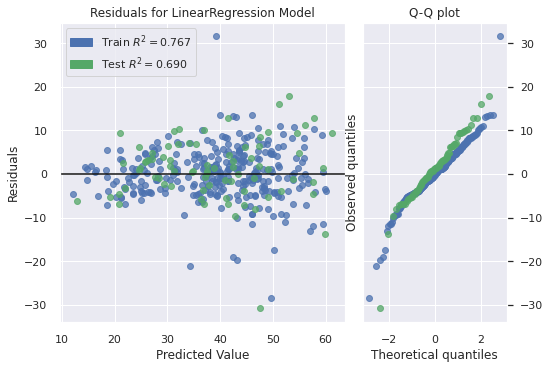

In [108]:
visualizer = ResidualsPlot(model_poly, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

https://www.kaggle.com/code/sohailadiab/real-estate-price-prediction/notebook